## RNN
### 영화 리뷰 감정 분석&  Seq2Seq기계번역

- 문장을 다른 문장으로 번역해주는 모델
- parallel corpora(병렬 말뭉치)- 원문과 번역문이 쌍을 이루는 형태의 많은 텍스트 데이터가 필요

이번 Seq2Seq 모델은 아주 간소화 되어있다.

- **encoder** : 외국어 문장을 읽고 의미를 이해한다
- **decoder** : 외국어 문장의 의미를 ㅐㅇ각하면서 한국어 단어를 한 자 한 자 문맥에 맞게 적어나간다.

### ENCODER(다대일)
- 원문 속의 모든 단어를 입력 받아 문장의 뜻을 내포하는 하나의 고정크기 텐서(문맥 텐서)를 만듦
- 인코더 RNN은 원문 속의 토큰을 차례대로 입력받음
- 원문 마지막 토큰에 해당하는 은닉 벡터는 원문의 뜻을 모두 내포하는 문맥 벡터임

### DECODER(일대다)
- 인코더에게서 원문 문맥 벡터를 이어받아 번역문 속의 토큰을 차례대로 예상
- 디코더가 번역문의 단어나 토큰을 출력할 때 인코더로부터 정보를 전달 받아야함

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt


Bad key "text.kerning_factor" on line 4 in
C:\Users\woojung\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


* 간단히 영어에서 스페인어로 번역할 것이므로, 단어 단위의 임베딩이 아닌 글자 단위의 임베딩을 사용

In [3]:
vocab_size = 256  # 총 아스키 코드 개수
x_ = list(map(ord, "hello"))  # 아스키 코드 리스트로 변환
y_ = list(map(ord, "hola"))   # 아스키 코드 리스트로 변환
print("hello -> ", x_)
print("hola  -> ", y_)

hello ->  [104, 101, 108, 108, 111]
hola  ->  [104, 111, 108, 97]


In [4]:
## 파이토치 텐서로 변경
x = torch.LongTensor(x_)
y = torch.LongTensor(y_)

In [5]:
class Seq2Seq(nn.Module):
    def __init__(self, vocab_size, hidden_size):
        super(Seq2Seq, self).__init__()
        self.n_layers = 1 
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, hidden_size) #본래 원문용 임베딩하나와 번역문용 임베딩 하나씩 제작해줘야 함
        self.encoder = nn.GRU(hidden_size, hidden_size)
        self.decoder = nn.GRU(hidden_size, hidden_size)
        self.project = nn.Linear(hidden_size, vocab_size) #디코더가 번역문의 다음 토큰을 예상해내는 작은 신경망

    def forward(self, inputs, targets):
        ### ENCODER ####
        embedding = self.embedding(inputs).unsqueeze(1)
        ##인코더에 입력되는 원문을 구성하는 모든 문자을 임베딩시킴
        initial_state = self._init_state() #인코더의 첫번째 은닉 벡터 
        # embedding = [seq_len, batch_size, embedding_size]
        
        # 인코더 실행
        encoder_output, encoder_state = self.encoder(embedding, initial_state) #input(embedding) -> 첫번째 은닉벡터(initial_state)
        # encoder_output = [seq_len, batch_size, hidden_size]
        # encoder_state  = [n_layers, seq_len, hidden_size] : 문맥벡터임

        #### DECODER ####
        # 디코더가 번역문의 첫번째 토큰을 예상하려면 인코더의 문맥 벡터와 문장 시작 토큰을 입력 데이터로 받아야 함
        ## 문장 시작 토큰은 실제로 문장에는 나타나지 않지만, 디코더가 정상적으로 작동할 수 있도록 인위적으로 넣은 토큰
        ## 문장의 시작을 알리기 위함 -> 아스키 값으로 공백 문자 null(0) 설정
        decoder_state = encoder_state
        decoder_input = torch.LongTensor([0]) 
        
        # 디코더 실행
        outputs = [] #여기에 결과 토큰 저장
        
        for i in range(targets.size()[0]):
            decoder_input = self.embedding(decoder_input).unsqueeze(1)
            decoder_output, decoder_state = self.decoder(decoder_input, decoder_state)
            projection = self.project(decoder_output) #예측
            outputs.append(projection)
            
            #### Teacher Forcing 사용####
            # 많은 데이터에서는 디코더가 예측한 토큰을 다음 반복에서 입력될 토큰으로 갱신해주는 것이 정석
            # 하지만 학습이 아직 되지않은 상태의 모델은 잘못된 예측 토큰을 입력으로 사용될 수 있으므로, Teacher Forcing 사용
            decoder_input = torch.LongTensor([targets[i]])
            # 디코더 학습 시 실제 번역문의 토큰을 디코더의 전 출력값 대신 입력으로 사용해 학습을 가속하는 방법
            # 번역문의 i번째 토큰에 해당하는값 targets[i]를 디코더의 입력값으로 설정

        outputs = torch.stack(outputs).squeeze()
        return outputs
    
    def _init_state(self, batch_size=1):
        weight = next(self.parameters()).data
        return weight.new(self.n_layers, batch_size, self.hidden_size).zero_()

In [6]:
seq2seq = Seq2Seq(vocab_size, 16) 

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(seq2seq.parameters(), lr=1e-3)

In [8]:
log = []
for i in range(1000):
    prediction = seq2seq(x, y)
    loss = criterion(prediction, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_val = loss.data
    log.append(loss_val)
    if i % 100 == 0:
        print("\n 반복:%d 오차: %s" % (i, loss_val.item()))
        _, top1 = prediction.data.topk(1, 1)
        print([chr(c) for c in top1.squeeze().numpy().tolist()])


 반복:0 오차: 5.425503253936768
['L', '2', 'ï', 'ï']

 반복:100 오차: 2.1205146312713623
['h', 'o', 'o', 'a']

 반복:200 오차: 0.49588334560394287
['h', 'o', 'l', 'a']

 반복:300 오차: 0.23068371415138245
['h', 'o', 'l', 'a']

 반복:400 오차: 0.14670364558696747
['h', 'o', 'l', 'a']

 반복:500 오차: 0.10527355968952179
['h', 'o', 'l', 'a']

 반복:600 오차: 0.08054342120885849
['h', 'o', 'l', 'a']

 반복:700 오차: 0.06417083740234375
['h', 'o', 'l', 'a']

 반복:800 오차: 0.05259435251355171
['h', 'o', 'l', 'a']

 반복:900 오차: 0.04402364045381546
['h', 'o', 'l', 'a']


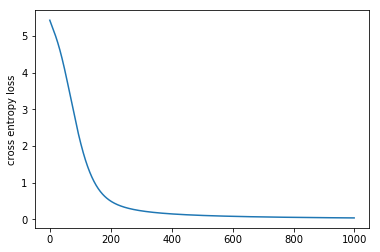

In [9]:
plt.plot(log)
plt.ylabel('cross entropy loss')
plt.show()